# GraphDatabase-CombinedTransportNetwork

In [13]:
import numpy as np
import neo4j
import pandas as pd
from neo4j import GraphDatabase
import time
from py2neo import Graph,Node,Relationship
import matplotlib.pyplot as plt
import os
import Parameters


In [14]:
from Res_DataFrames import *

In [15]:
from Res_DataFrames_all import *

### NEO4J installation

In [16]:
URL = "bolt://127.0.0.1:7687"
USER = "neo4j"
PASSWORD = "cassiopeedrt"

#graph = GraphDatabase.driver(URI, auth=(USER, PASSWORD))
graph = Graph(URL, auth=(USER, PASSWORD))

#### Tests (voir si ça fonctionne)

In [17]:
#Cypher Query
number_of_stop_nodes= "MATCH(s:Stop) RETURN Count(s)"
number_of_stoptime_nodes= "MATCH(t:Stoptime) RETURN Count(t)"
number_of_centroid_nodes= "MATCH(c:Centroid) RETURN Count(c)"
#Evaluate the Cypher query
result_stop=graph.evaluate(number_of_stop_nodes)
result_stoptime=graph.evaluate(number_of_stoptime_nodes)
result_centroid=graph.evaluate(number_of_centroid_nodes)
#Print the result
print(f"No of Stop node is {result_stop} & No of stoptime node is {result_stoptime} & No of centroids node is {result_centroid}")

No of Stop node is 749 & No of stoptime node is 0 & No of centroids node is 999


Text(0, 0.5, 'No Of Nodes')

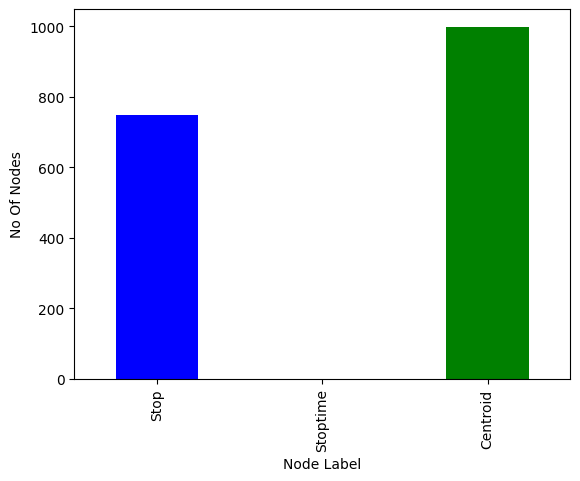

In [18]:
df_result_count=pd.Series({"Stop":result_stop,"Stoptime":result_stoptime,"Centroid":result_centroid})
df_result_count.plot(kind = "bar",color=["blue","darkorange","green"])
plt.xlabel("Node Label")
plt.ylabel("No Of Nodes")

### Appel graphs Cathia

#### Trouver les stops dont l'accessibilité est la plus faible sans DRT

In [19]:
#Création d'un dataframe avec les résultats calculés
path_res_sansDRT = os.path.normpath('Results/res/res_1_min_all_sansDRT.txt')
res_1_min_sansDRT = pd.read_csv(path_res_sansDRT)
res_1_min_sansDRT.head()

,centroid,nb_destinations,trajets,trajets_ok,nb_station_DRT,DRT,DRT_ok,WALK_to_station_DRT,WALK,inaccessibilite
0,0,16,14,0,0,0,0,0,14,145302.2196
1,1,27,22,0,0,0,0,0,22,244999.1688
2,2,37,30,0,0,0,0,0,30,329627.1708
3,3,47,37,6,0,0,0,0,37,393695.6172
4,4,55,45,6,0,0,0,0,45,442849.0920


On calcule l'inaccessibilité globale comme la moyenne des inaccessibilités

In [34]:
somme_inacc = res_1_min_sansDRT['inaccessibilite'].sum()
print(somme_inacc)
nb_centroids = res_1_min_sansDRT.shape[0]
print(nb_centroids)
print(somme_inacc/nb_centroids)

1609500450.4512
1167
1379177.7638827763


On cherche les stops pour lesquels les accessibilités sont les plus faibles : 
(à faire : mettre une condition pour que les stops soient suffisamment séparés)

In [36]:
# On associe les accessibilités calculées aux stops :
path_stops = os.path.normpath('Data/stops.txt')
stops = pd.read_csv(path_stops)

# Obtenir les identifiants des stops
stop_id = stops['stop_id'].tolist()

# Filtrer les lignes du dataframe res_1_min_sansDRT en fonction des identifiants des stops
res_1_min_sansDRT_stops = res_1_min_sansDRT[res_1_min_sansDRT['centroid'].isin(stop_id)]
#print(res_1_min_sansDRT_stops)

m = 5 # stations d'accessibilités minimales pour placer des DRT 

# Trier le DataFrame par ordre croissant en fonction de la colonne accessibilite
res_1_min_stops_sorted = res_1_min_sansDRT_stops.sort_values('inaccessibilite')

# Extraire les m premières lignes du DataFrame trié
res_1_min_top_inacc = res_1_min_stops_sorted.tail(m)
#print(res_1_min_top)
print(res_1_min_top_inacc['centroid'].tolist())

#m = 10 : [659, 823, 822, 656, 576, 495, 577, 616, 617, 657]
#m = 5 : [495, 577, 616, 617, 657]

[495, 577, 616, 617, 657]


On affiche la carte des accessibilités sans DRT :

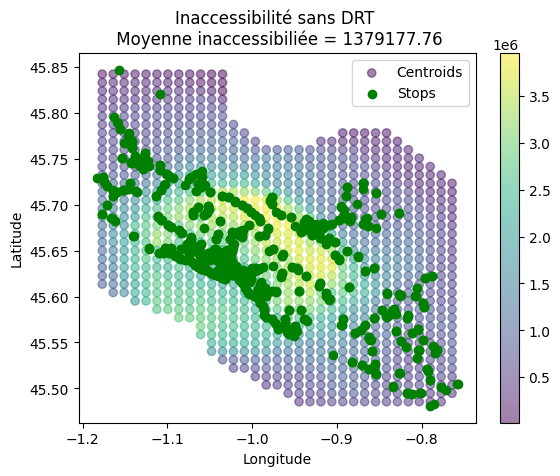

In [35]:
################################################################################
# Import des données
################################################################################
path_data_centroids = os.path.normpath('.\Data\centroids.txt')

data_centroids = pd.read_csv(path_data_centroids)
#data_centroids.head()

# On garde une seule ligne par centroide afin d'avoir ses coordonnées (latitude + longitude)
data_centroids_drop = data_centroids.drop_duplicates(subset='centroid_id')

# Pour afficher les stops 
path_stops = os.path.normpath('Data/stops.txt')
stops = pd.read_csv(path_stops)

# Fusionner data_centroids_drop avec res_1_min sur la colonne 'centroid_id' pour avoir les coordonnées et les inaccessibilités
inacc_coordonnees = data_centroids_drop.merge(res_1_min_sansDRT, left_on='centroid_id', right_on='centroid')

################################################################################
#calcul inaccessibilité moyenne 
################################################################################
somme_inacc = res_1_min_sansDRT['inaccessibilite'].sum()
nb_centroids = res_1_min_sansDRT.shape[0]
print()
inacc_moy = somme_inacc/nb_centroids

################################################################################
# Tracer le graphique
################################################################################
# Sélectionner les colonnes nécessaires pour tracer le graphique
x = inacc_coordonnees['centroid_lon']
y = inacc_coordonnees['centroid_lat']
c = inacc_coordonnees['inaccessibilite']

plt.scatter(x, y, c=c, alpha=0.5, marker='o', label="Centroids")
# Ajouter une légende pour la couleur
plt.colorbar()
#res_1_min_top10['inaccessibilite']
plt.scatter(stops['stop_lon'], stops['stop_lat'], c='green', label = 'Stops')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.legend()
plt.title('Inaccessibilité sans DRT \n Moyenne inaccessibilitée = {:.2f}'.format(inacc_moy))
plt.show()

#### m = 5

#### m = 10 

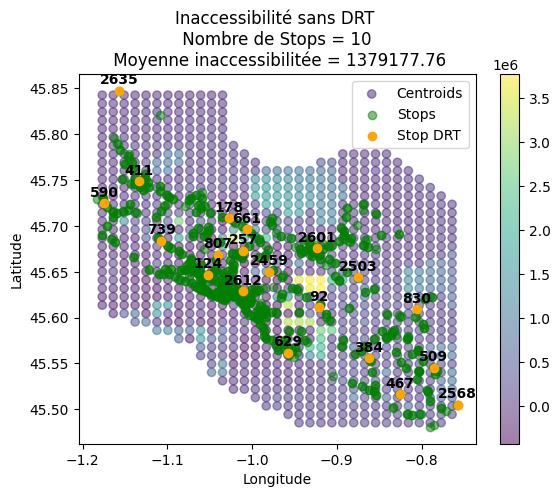

In [42]:
m = 10
################################################################################
# Import des données
################################################################################
#Création d'un dataframe avec les résultats calculés
path_res_10DRT = os.path.normpath('Results/res/res_1_min_all_10DRT.txt')
res_1_min_10DRT = pd.read_csv(path_res_10DRT)
res_1_min_10DRT.head()

# Exécuter le fichier "mon_script.py" en utilisant Python
path_data_centroids = os.path.normpath('.\Data\centroids.txt')

data_centroids = pd.read_csv(path_data_centroids)
data_centroids.head()

data_centroids_drop = data_centroids.drop_duplicates(subset='centroid_id')

path_stops = os.path.normpath('Data/stops.txt')
path_stops_drt = os.path.normpath('./Stations/list_station_id.txt')

stops = pd.read_csv(path_stops)
stops_drt = pd.read_csv(path_stops_drt)

# Fusionner les deux DataFrames sur la colonne 'stop_id'
stops_filtered = pd.merge(stops, stops_drt[['station_list']], how='inner', left_on='stop_id', right_on='station_list')

# Fusionner data_centroids_drop avec res_1_min sur la colonne 'centroid_id'
merged_data = data_centroids_drop.merge(res_1_min_10DRT, left_on='centroid_id', right_on='centroid')

################################################################################
#calcul inaccessibilité moyenne 
################################################################################
somme_inacc = res_1_min_sansDRT['inaccessibilite'].sum()
nb_centroids = res_1_min_sansDRT.shape[0]
print()
inacc_moy = somme_inacc/nb_centroids

################################################################################
# Tracer le graphique
################################################################################
# Sélectionner les colonnes nécessaires pour tracer le graphique
x = merged_data['centroid_lon']
y = merged_data['centroid_lat']
c = merged_data['inaccessibilite']

# Tracer le graphique
plt.scatter(x, y, c=c, alpha=0.5, marker='o', label="Centroids")
# Ajouter une légende pour la couleur
plt.colorbar()
#res_1_min_top10['inaccessibilite']
plt.scatter(stops['stop_lon'], stops['stop_lat'], c='green', label = 'Stops', alpha = 0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.scatter(stops_filtered['stop_lon'], stops_filtered['stop_lat'], c='orange', label="Stop DRT")

# Ajouter les étiquettes des points (stop_id) en gras et en rouge
for i in range(len(stops_filtered)):
    plt.annotate(stops_filtered['stop_id'][i], xy=(stops_filtered['stop_lon'][i], stops_filtered['stop_lat'][i]), textcoords='offset points', xytext=(0,5), ha='center', fontweight='bold')
plt.legend()
plt.title('Inaccessibilité sans DRT \n Nombre de Stops = {} \n Moyenne inaccessibilitée = {:.2f}'.format(m, inacc_moy))
plt.show()

faire la meme chose mais pas les 10 pires : mettre un, calcul, mettre un deuxième,...
calculer l'accessibilité quand on rajoute un DRT sans tout recalculer